In [13]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from collections import Counter
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K

# Set memory growth before initializing TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(len(gpus), "Physical GPUs,", "Logical GPUs initialized successfully")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available")

# Define the base directory where the dataset is originally located
source_base_dir = '/kaggle/input/pixelated-image-dataset/Image_Processing'  # Update this path

# Define the base directory for the working directory on Kaggle
base_dir = '/kaggle/working/'

# Define paths for original and pixelated images in the source directory
original_dir = os.path.join(source_base_dir, 'Original')
pixelated_dir = os.path.join(source_base_dir, 'Pixelated')

# Define paths for train and test directories in the working directory
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create the necessary directories in the working directory
os.makedirs(os.path.join(train_dir, 'Original'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'Pixelated'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'Original'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'Pixelated'), exist_ok=True)

# Define the split ratio for training and testing
split_ratio = 0.8

def split_data(original_dir, pixelated_dir, train_dir, test_dir, split_ratio):
    original_files = os.listdir(original_dir)
    pixelated_files = os.listdir(pixelated_dir)

    # Ensure there is a corresponding pixelated image for each original image
    paired_files = [(file, file) for file in original_files if file in pixelated_files]

    random.shuffle(paired_files)
    split_index = int(len(paired_files) * split_ratio)
    train_files = paired_files[:split_index]
    test_files = paired_files[split_index:]

    for original_file, pixelated_file in train_files:
        shutil.copy(os.path.join(original_dir, original_file), os.path.join(train_dir, 'Original', original_file))
        shutil.copy(os.path.join(pixelated_dir, pixelated_file), os.path.join(train_dir, 'Pixelated', pixelated_file))
    
    for original_file, pixelated_file in test_files:
        shutil.copy(os.path.join(original_dir, original_file), os.path.join(test_dir, 'Original', original_file))
        shutil.copy(os.path.join(pixelated_dir, pixelated_file), os.path.join(test_dir, 'Pixelated', pixelated_file))

# Split the data ensuring the pairs are maintained
split_data(original_dir, pixelated_dir, train_dir, test_dir, split_ratio)

# Define a directory to save augmented images before training
augmented_dir = os.path.join(base_dir, 'augmented_train')

# Remove the augmented directory if it exists
if os.path.exists(augmented_dir):
    shutil.rmtree(augmented_dir)
    print(f"Removed existing directory: {augmented_dir}")

# Create necessary directories in the augmented directory
os.makedirs(os.path.join(augmented_dir, 'Original'), exist_ok=True)
os.makedirs(os.path.join(augmented_dir, 'Pixelated'), exist_ok=True)

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 16

# Create an image data generator for augmentation
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow from the training directory to generate augmented images
original_gen = augment_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    classes=['Original'],
    save_to_dir=os.path.join(augmented_dir, 'Original'),
    save_prefix='aug_',
    save_format='jpeg'
)

pixelated_gen = augment_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    classes=['Pixelated'],
    save_to_dir=os.path.join(augmented_dir, 'Pixelated'),
    save_prefix='aug_',
    save_format='jpeg'
)

# Generate a specific number of augmented images
num_augmented_images = 1000  # Number of augmented images to generate per class

for _ in range(num_augmented_images // batch_size):
    next(original_gen)
    next(pixelated_gen)

# Create image data generators for training and testing
train_generator = augment_datagen.flow_from_directory(
    augmented_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Define a more complex CNN model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3),  input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Conv2D(32, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Conv2D(256, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),

    # Fifth Convolutional Block
    Conv2D(512, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),

    # Global Average Pooling Layer
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    
    # Output Layer
    Dense(1, activation='sigmoid')
])

# Compile the model with Nadam optimizer and binary cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set the checkpoint path with the .keras extension
checkpoint_path = '/kaggle/working/best_pixelated_image_detector.keras'

# Create the ModelCheckpoint callback with the updated path
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model with class weights and adaptive learning rate
model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[reduce_lr, checkpoint]
)

# Load the best model after training
best_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')




# Return the best model
best_model


2 Physical GPUs, Logical GPUs initialized successfully
Removed existing directory: /kaggle/working/augmented_train
Found 1244 images belonging to 1 classes.
Found 1244 images belonging to 1 classes.
Found 1984 images belonging to 2 classes.
Found 2340 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/124 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.5938 - loss: 0.9641 

W0000 00:00:1724007993.983336     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5127 - loss: 0.8641

W0000 00:00:1724008021.389703     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1: Train Accuracy: 50.96%
Epoch 1: Validation Accuracy: 57.85%
124/124 ━━━━━━━━━━━━━━━━━━━━ 79s 518ms/step - accuracy: 0.5127 - loss: 0.8638 - val_accuracy: 0.5085 - val_loss: 0.6998 - learning_rate: 0.0010
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5083 - loss: 0.8001Epoch 2: Train Accuracy: 51.56%
Epoch 2: Validation Accuracy: 58.37%
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - accuracy: 0.5084 - loss: 0.7999 - val_accuracy: 0.5137 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5911 - loss: 0.6966Epoch 3: Train Accuracy: 59.07%
Epoch 3: Validation Accuracy: 60.38%
124/124 ━━━━━━━━━━━━━━━━━━━━ 65s 510ms/step - accuracy: 0.5911 - loss: 0.6966 - val_accuracy: 0.5338 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6414 - loss: 0.6634Epoch 4: Train Accuracy: 59.68%
Epoch 4: Validation Accuracy: 65.12%
124/124 ━━━━━━━━━━━━━━━━━━━━ 65

W0000 00:00:1724009343.750663     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.6963 - loss: 0.5545
Test Accuracy: 76.44%


<Sequential name=sequential_12, built=True>

In [47]:
import time
import numpy as np
from sklearn.metrics import roc_curve
from tensorflow.keras import backend as K

def measure_inference_speed(model, generator, num_samples=10):
    # Resetting the generator by creating a new instance
    generator.reset()
    
    # Pre-run dummy inference to account for GPU warm-up (if using a GPU)
    dummy_images, _ = next(generator)
    model.predict(dummy_images[:num_samples])

    # Select the first `num_samples` images from the generator
    images, _ = next(generator)
    images = images[:num_samples]

    # Measure inference time
    start_time = time.time()
    model.predict(images)
    end_time = time.time()

    total_time = end_time - start_time
    avg_time_per_image = total_time / num_samples
    fps = 1 / avg_time_per_image
    return fps, avg_time_per_image

# Measure inference speed
fps, avg_time_per_image = measure_inference_speed(model, test_generator, num_samples=10)

print(f'Inference Speed: {fps:.2f} FPS')
print(f'Average Time per Image: {avg_time_per_image:.4f} seconds')


# Adjust Decision Threshold
y_true = []
y_pred = []
test_generator.reset()  # Ensure the generator is reset before looping through it

for i in range(len(test_generator)):
    X_batch, y_batch = next(test_generator)
    y_true.extend(y_batch)
    y_pred.extend(model.predict(X_batch).flatten())

# Calculate the best threshold to minimize false positives
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
best_threshold = thresholds[np.argmax(tpr - fpr)]
false_positive_rate = fpr[np.argmax(tpr - fpr)]




# Clear session (optional, but useful for some environments)
K.clear_session()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Inference Speed: 111.41 FPS
Average Time per Image: 0.0090 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━

In [6]:
import time
import numpy as np
from sklearn.metrics import roc_curve
from tensorflow.keras import backend as K

def measure_inference_speed(model, generator, num_samples=100):
    # Resetting the generator by creating a new instance
    generator.reset()
    
    # Pre-run dummy inference to account for GPU warm-up (if using a GPU)
    dummy_images, _ = next(generator)
    model.predict(dummy_images[:num_samples])

    # Select the first `num_samples` images from the generator
    images, _ = next(generator)
    images = images[:num_samples]

    # Measure inference time
    start_time = time.time()
    model.predict(images)
    end_time = time.time()

    total_time = end_time - start_time
    avg_time_per_image = total_time / num_samples
    fps = 1 / avg_time_per_image
    return fps, avg_time_per_image

# Measure inference speed
fps, avg_time_per_image = measure_inference_speed(model, test_generator, num_samples=32)




# Adjust Decision Threshold
y_true = []
y_pred = []
test_generator.reset()  # Ensure the generator is reset before looping through it

for i in range(len(test_generator)):
    X_batch, y_batch = next(test_generator)
    y_true.extend(y_batch)
    y_pred.extend(model.predict(X_batch).flatten())

# Calculate the best threshold to minimize false positives
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
best_threshold = thresholds[np.argmax(tpr - fpr)]
false_positive_rate = fpr[np.argmax(tpr - fpr)]

print(f'Best threshold: {best_threshold:.2f}')
print(f'False Positive Rate: {false_positive_rate:.2%}')



# Clear session (optional, but useful for some environments)
K.clear_session()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


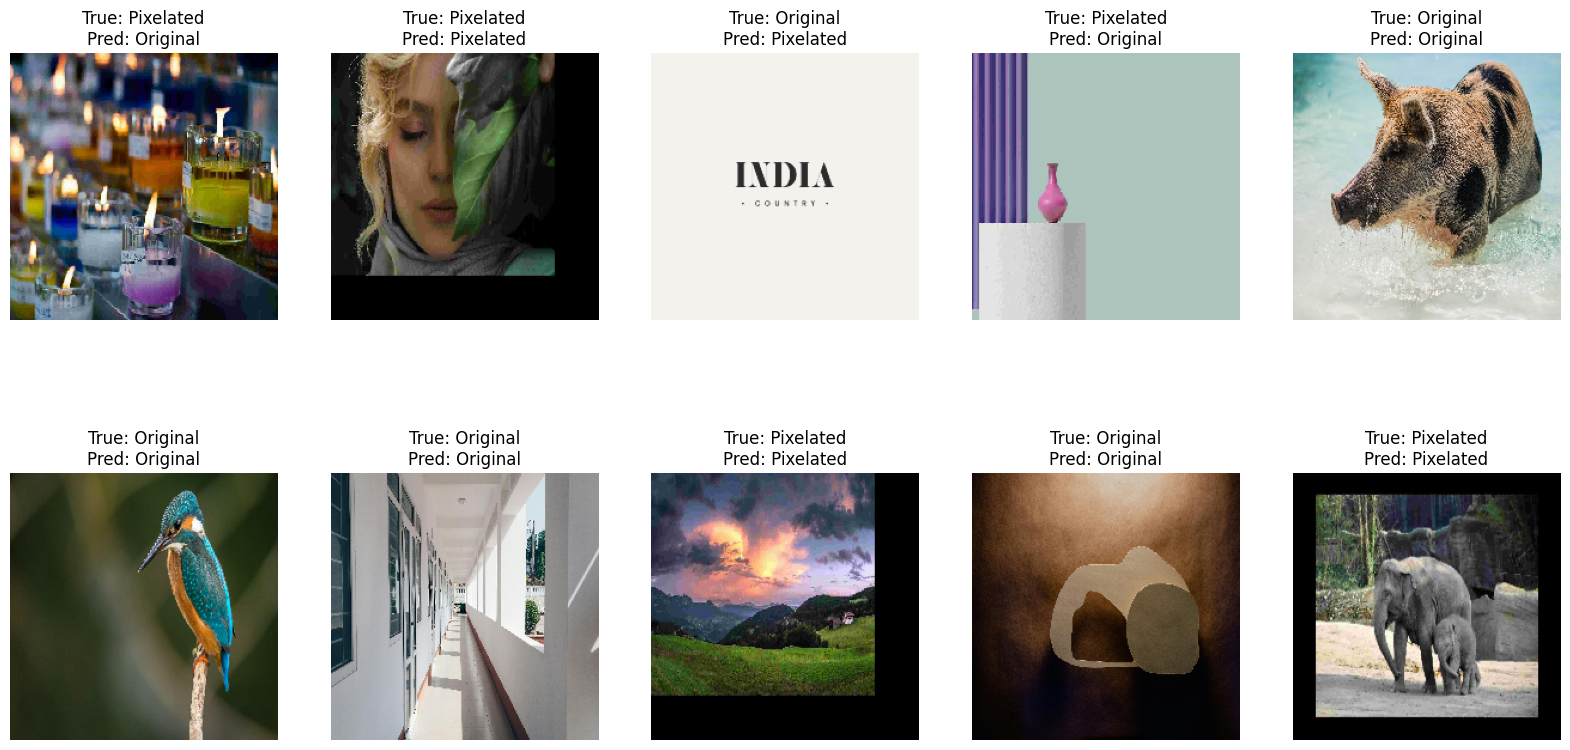

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

# Load a batch of images from the test set
test_batch, test_labels = next(test_generator)

# Get indices of pixelated images in the batch
pixelated_indices = np.where(test_labels == 1)[0]

# Ensure that at least 2 pixelated images are selected
if len(pixelated_indices) < 2:
    raise ValueError("Not enough pixelated images in the batch. Consider increasing the batch size or running multiple batches.")

# Select 2 pixelated images and 8 other images randomly
selected_pixelated_indices = random.sample(list(pixelated_indices), 2)
other_indices = random.sample([i for i in range(len(test_labels)) if i not in selected_pixelated_indices], 8)
selected_indices = selected_pixelated_indices + other_indices

# Get the selected images and their true labels
selected_images = test_batch[selected_indices]
selected_true_labels = test_labels[selected_indices]

# Predict using the model
predicted_probs = model.predict(selected_images)
predicted_labels = (predicted_probs > 0.47).astype(int)

# Plot and print predictions
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(selected_images[i])
    true_label = 'Pixelated' if selected_true_labels[i] == 1 else 'Original'
    predicted_label = 'Pixelated' if predicted_labels[i] == 1 else 'Original'
    plt.title(f'True: {true_label}\nPred: {predicted_label}')
    plt.axis('off')
plt.show()
